In [21]:
# %pip install opencv-python
# %pip install --upgrade numpy

In [22]:
# utility libraries
import numpy as np
import cv2
import sys
from skimage import io
# import preprocessing module
sys.path.append('../')
from Preprocessing import preprocessing as pp
import threading

In [23]:
def extract_roi(edge_image, colored_image):

    edge_image  = (edge_image * 255).astype('uint8')
    contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # List to store extracted ROIs
    extracted_rois = []

    # Minimum area threshold to avoid small objects and retrieve only potential ROIs
    min_area = 1000

    # Create a list to hold the threads
    threads = []

    def process_contour_sublist(index, chunk_size):
        for i in range(index, index + chunk_size):
            # Calculate area of the contour
            area = cv2.contourArea(contours[i])

            # Get bounding rectangle of the contour
            # x, y: Coordinates of the top-left corner
            # w, h: Width and height of the rectangle
            x, y, w, h = cv2.boundingRect(contours[i])

            # Skip small contours
            if area < min_area:
                continue

            # Gets the smallest possible circle that encloses the contour with its centroid and radius
            centroid, radius = cv2.minEnclosingCircle(contours[i])

            # Calculate the area of the enclosing circle
            circle_area = np.pi * (radius ** 2)

            # add the contour to the list of circle contours
            if np.isclose(area, circle_area, rtol=0.2): 
                #         img_copy = colored_image.copy()
                # # # Create an empty mask
                # # mask = np.zeros_like(img_copy)
                # # # Draw the contour on the mask
                # # cv2.drawContours(mask, [contour], 0, (255, 255, 255), thickness=cv2.FILLED)
                # # # Invert the mask (to keep the area inside the contour)
                # # mask_inv = cv2.bitwise_not(mask)
                # # # Set all areas outside the contour to white
                # # result = cv2.bitwise_and(img_copy, mask)
                # # result += mask_inv
                # # Use the bounding rectangle coordinates to create the sub-image
                # sub_image = colored_image[y:y+h, x:x+w]
                # # cv2.rectangle(colored_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

                # # # Create the Gaussian blur
                # # gauss = cv2.GaussianBlur(sub_image, (9,9), 10.0)
                # # # Create the unsharp image by subtracting the Gaussian blur
                # # unsharp_image = cv2.addWeighted(sub_image, 1.5, gauss, -0.5, 0, sub_image)
                #         # Use the bounding rectangle coordinates to create the sub-image
                sub_image = colored_image[y:y+h, x:x+w]

                # Store extracted ROI information
                extracted_rois.append(sub_image)

    # Calculate the size of each chunk
    chunk_size = len(contours) // 16

    # Create and start a thread for each sublist
    for i in range(16):
        thread = None
        if(i == 15):
            thread = threading.Thread(target=process_contour_sublist, args=(i * chunk_size, chunk_size + len(contours) % 16))
        else:    
            thread = threading.Thread(target=process_contour_sublist, args=(i * chunk_size, chunk_size))
        thread.start()
        threads.append(thread)

    # Wait for all threads to finish
    for thread in threads:
        thread.join()

    # Return the list of extracted ROIs
    return extracted_rois

In [24]:
'''
Testing
'''
# Load the image
image = io.imread("./30-mph-speed-limit-board-on-uk-roads-2CBGN4C.jpg")

# img = image[:, 2 * (image.shape[1] // 3):]
# img = img[img.shape[0] // 3: 2 * (img.shape[0] // 3), :]

# image = cv2.resize(image, (1280, 720))

# Convert the image to grayscale
gray_image = pp.gray_image(image)

afterGamma = pp.HistogramEqualization(gray_image)  

# Apply edge detection
edge_image = pp.LoGEdgeDetection(afterGamma)

In [25]:

# Extract ROIs
rois = extract_roi(edge_image, image)

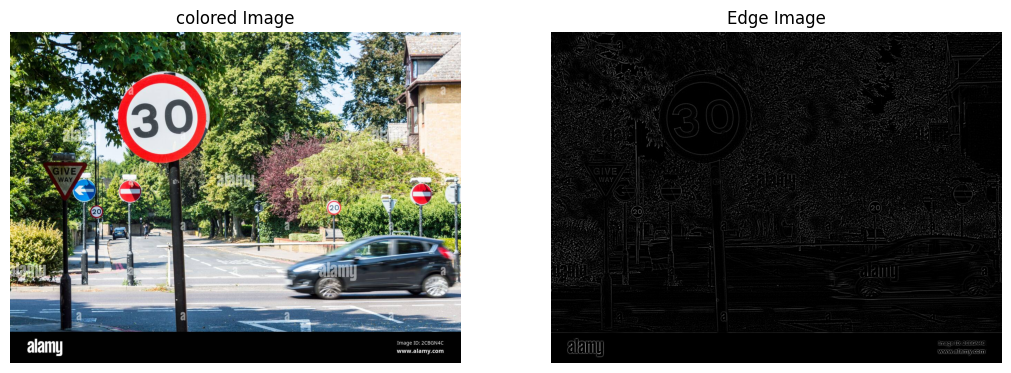

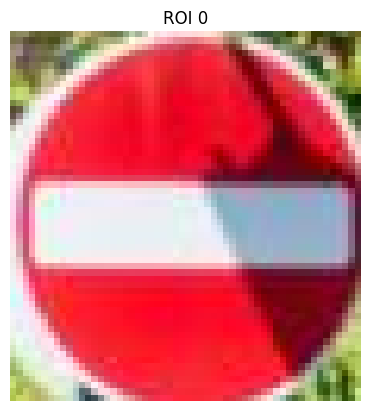

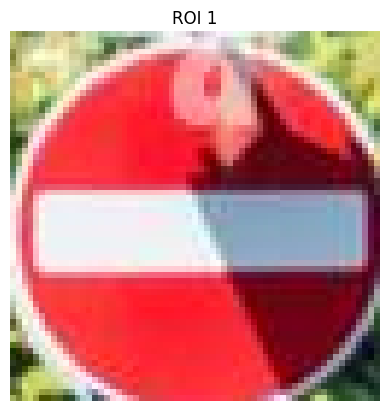

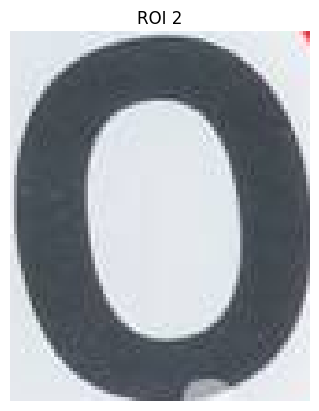

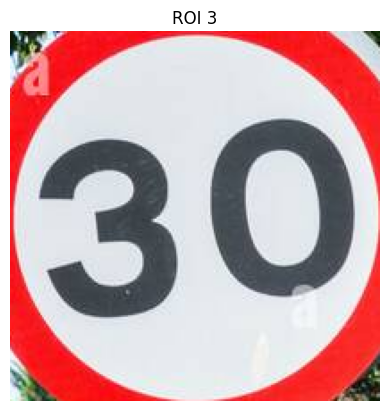

In [26]:
pp.show_images([image, edge_image], ["colored Image", "Edge Image"])
for i in range(len(rois)):
  pp.show_images([rois[i]], [f"ROI {i}"])